# Árboles de Decisión Random Forest (Regresión)

## 1. Librerias y configuraciones previas


In [1]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Almacenar en caché los resultados de funciones en el disco
# ==============================================================================
import joblib


# Gestion de librerias
# ==============================================================================
from importlib import reload


# Preprocesado y modelado
# ==============================================================================

#creación de modelos
from sklearn.ensemble import RandomForestRegressor


#Escalar Variables
from sklearn.preprocessing import MinMaxScaler

#import statsmodels.api as sm
import math

#evaluacion de variables
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.inspection import permutation_importance
import multiprocessing


# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns


# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

## 2. Funciones

In [2]:
#reload(utils.funciones)

# Funciones externas
# ==============================================================================
from utils.funciones import multiple_plot

## 3. Carga del dataset

In [3]:
#Se crea un dataframe d con los datos obtenidos de archivo de entrada
d=pd.read_csv('./datasets/01_carDetailsV4_Prep.csv')

In [4]:
## Cargar datos con colab
## =============================================================================

#from google.colab import drive 
#import os

#drive.mount('/gdrive')

In [5]:
#os.chdir("/gdrive/MyDrive/ModelosCuantitativosPython/Notebooks")
#!ls

In [6]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1441 entries, 0 to 1440
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Price               1441 non-null   float64
 1   Year                1441 non-null   float64
 2   Kilometer           1441 non-null   float64
 3   Engine              1441 non-null   float64
 4   Length              1441 non-null   float64
 5   Width               1441 non-null   float64
 6   Height              1441 non-null   float64
 7   Seating Capacity    1441 non-null   float64
 8   Fuel Tank Capacity  1441 non-null   float64
 9   Fuel Type           1441 non-null   object 
 10  Transmission        1441 non-null   object 
 11  Owner               1441 non-null   object 
 12  Seller Type         1441 non-null   object 
 13  Drivetrain          1441 non-null   object 
 14  PriceRange          1441 non-null   int64  
dtypes: float64(9), int64(1), object(5)
memory usage: 169.0+

## 4. Visualización de datos

### Variables de entrada

In [7]:
#Lista de variables categóricas
catCols = d.select_dtypes(include = ["object", 'category']).columns.tolist()

d[catCols].head(2)

,Fuel Type,Transmission,Owner,Seller Type,Drivetrain
0,Petrol,Automatic,First,Individual,FWD
1,Diesel,Automatic,First,Corporate,AWD


In [8]:
#Lista de variables numéricas

numCols=d.select_dtypes(include = ['float64','float64','int32','int64']).columns.tolist()
d[numCols].head(2)

,Price,Year,Kilometer,Engine,Length,Width,Height,Seating Capacity,Fuel Tank Capacity,PriceRange
0,9540.0,2021.0,9000.0,1199.0,3993.0,1677.0,1532.0,5.0,35.0,1
1,10500.0,2014.0,99000.0,2199.0,4690.0,1880.0,1690.0,7.0,64.0,1


In [9]:
##Visualización de frecuencia de instancias para variables categóricas
#multiple_plot(3, d , catCols, None, 'countplot', 'Frecuencia de instancias para variables categóricas',30)

In [10]:
#Visualización por medio de gráficos de caja de bigotes para las variables categóricas con respecto al precio
#multiple_plot(3, d , catCols, 'Price', 'boxplot', 'Distribución de la variable Make vs. el Price',30)

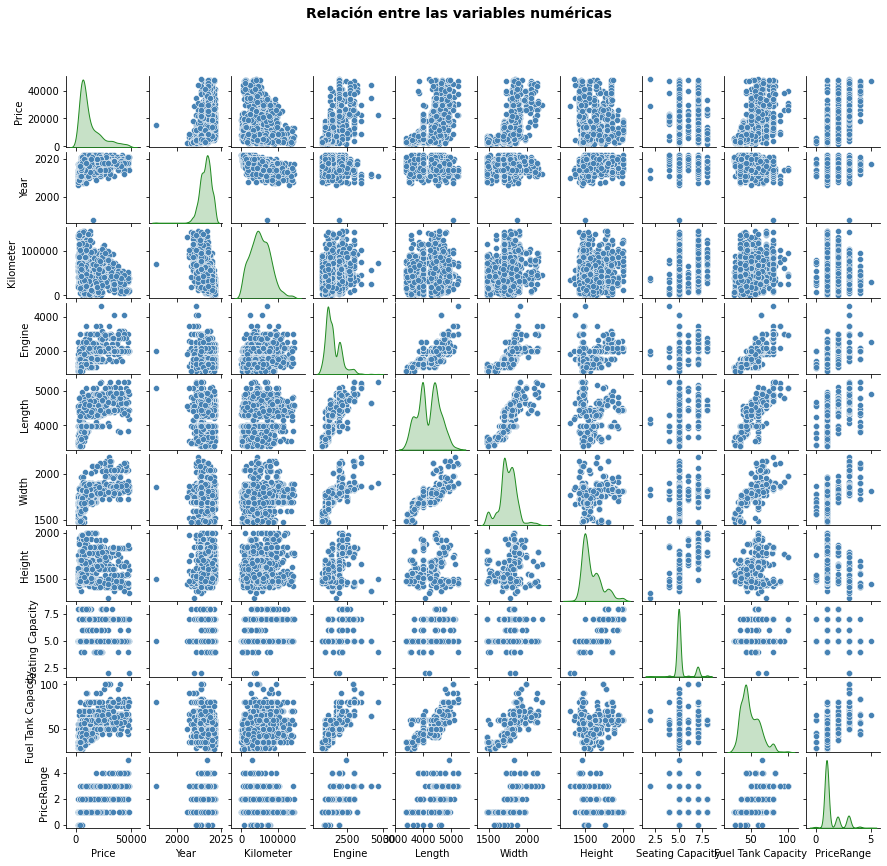

In [11]:
#Visualización de variables numéricas con respecto al precio
multiple_plot(1, d , numCols, None, 'scatterplot', 'Relación entre las variables numéricas',30)

In [12]:
#Eliminar la variable de salida de la lista de variable numéricas
numCols.remove('Price') 

### Variable de salida

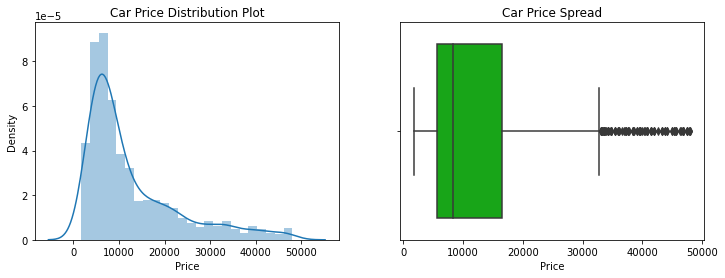

In [13]:
#Histográma y caja de bigotes del precio de los vehículos

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.title('Car Price Distribution Plot')
sns.distplot(d.Price)

plt.subplot(1,2,2)
plt.title('Car Price Spread')
sns.boxplot(x=d.Price, palette='nipy_spectral')

plt.show()

In [14]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)

print(d.Price.describe(percentiles = [0.25,0.50,0.75,0.85,0.90,0.95,0.975,1]))

count    1441
mean    12601
std     10255
min      1740
25%      5580
50%      8388
75%     16500
85%     22500
90%     28800
95%     35880
97.5%   41400
100%    48000
max     48000
Name: Price, dtype: float64


## 5. Preparación de datos

### Creación de Variables Dummies

In [15]:
# Aplicación de la función de get_dummies

d =pd.get_dummies(d, drop_first=1)

In [16]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1441 entries, 0 to 1440
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Price                   1441 non-null   float64
 1   Year                    1441 non-null   float64
 2   Kilometer               1441 non-null   float64
 3   Engine                  1441 non-null   float64
 4   Length                  1441 non-null   float64
 5   Width                   1441 non-null   float64
 6   Height                  1441 non-null   float64
 7   Seating Capacity        1441 non-null   float64
 8   Fuel Tank Capacity      1441 non-null   float64
 9   PriceRange              1441 non-null   int64  
 10  Fuel Type_Otro          1441 non-null   uint8  
 11  Fuel Type_Petrol        1441 non-null   uint8  
 12  Transmission_Manual     1441 non-null   uint8  
 13  Owner_Fourth            1441 non-null   uint8  
 14  Owner_Second            1441 non-null   

## 6. Creación del modelo

### Dividir el conjunto de datos

In [17]:
#Se establece las variables de entrada 'X' y la variable de salida 'y'

X = d.drop(columns = "Price")
y = d['Price']

In [18]:
# División de los datos en train y test

#En este caso, el 80% de los datos se utilizarán para entrenar el modelo. 

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1), 
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

### Escalar Variables

In [19]:
#Se establecen las variables numéricas a escalar

#Num_vars se le asigna la lista con las variables numerivas para posteriormente escalarlas
num_vars = numCols

print(num_vars)

['Year', 'Kilometer', 'Engine', 'Length', 'Width', 'Height', 'Seating Capacity', 'Fuel Tank Capacity', 'PriceRange']


In [20]:
#Escalar Variables númericas

pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Se crea un objeto MinMaxScaler
scaler = MinMaxScaler()

# Se escalan los valores del dataset entrenamiento y prueba de las columnas numéricas
X_train[num_vars] = scaler.fit_transform(X_train[num_vars])
X_test[num_vars] = scaler.transform(X_test[num_vars])

X_train[num_vars].head(2)

,Year,Kilometer,Engine,Length,Width,Height,Seating Capacity,Fuel Tank Capacity,PriceRange
99,0.8235,0.4393,0.1016,0.1992,0.2613,0.3195,0.5000,0.2192,0.2000
1251,0.8235,0.3630,0.1044,0.3231,0.3814,0.2908,0.5000,0.1370,0.2000


### Creación del modelo

Un Random Forest es un metaestimador que ajusta una serie de árboles de decisión de clasificación en varias submuestras del conjunto de datos y utiliza el promedio para mejorar la precisión predictiva y controlar el sobreajuste. 

**Parametros:**
- **n_estimators:** (default=100) número de árboles del bosque
- **max_depth:** (default=None) La profundidad máxima del árbol. Si es `None`, los nodos se expanden hasta que todas las hojas sean puras o hasta que todas las hojas contengan menos ejemplos del parametro min_samples_split.
- **max_features:** (default=1.0) El número de características a considerar al buscar la mejor división
    - auto, None o 1.0: max_features=n_features.
    - sqrt: max_features=sqrt(n_features).
    - log2: max_features=log2(n_features).

- **bootstrap:**(default=True) Si se utilizan muestras al construir árboles. Si es False, se usa todo el conjunto de datos para construir cada árbol.

- **oob_score:** (default=False) si usa ejemplos out-of-bag para estimar un score de generalización. Solo disponible si bootstrap = True.

In [21]:
# Creación del modelo
# ==============================================================================
modelRF = RandomForestRegressor(
            n_estimators = 10,
            criterion    = 'mse',
            max_depth    = None,
            max_features = 'auto',
            oob_score    = False,   #out-of-bag samples
            n_jobs       = -1,
            random_state = 123
         )


# Entrenamiento del modelo
# ==============================================================================
modelRF.fit(X_train, y_train)

RandomForestRegressor(criterion='mse', max_features='auto', n_estimators=10,
                      n_jobs=-1, random_state=123)

### Evaluación del modelo

#### Error Cuadráico Medio (rmse) y el Coeficiente de Determinación $R^2$

In [22]:
# Error de test del modelo inicial
# ==============================================================================
predicciones = modelRF.predict(X = X_test)

rmse = mean_squared_error(y_true  = y_test, y_pred  = predicciones, squared = False)
print(f"El error (rmse) de test es: {rmse}")

r2 = r2_score(y_test, predicciones)
print(f"El error (r2) de test es: {r2}")

El error (rmse) de test es: 2316.038209312836
El error (r2) de test es: 0.9461537715725372


## 7. Afinando el modelo (tuning)

### Preparacion de datos

In [23]:
# Nuevamente se asigna a 'X_Completo' y 'y_Completo' los datos entrada y salida respectivamente
X_Completo = X
y_Completo = y

# Se escalan los datos numéricos de entrada
X_Completo[num_vars] = scaler.fit_transform(X_Completo[num_vars])

In [24]:
# Guardar el scaler
joblib.dump(scaler, './modelos/scaler/minmaxFull_carDetailsV4.pkl')

['./modelos/scaler/minmaxFull_carDetailsV4.pkl']

Valor óptimo de n_estimators(árboles): 81


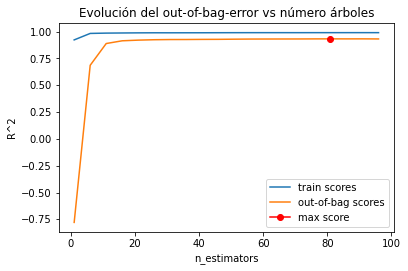

In [25]:
# Validación empleando el Out-of-Bag error : 

# ==============================================================================
train_scores = []
oob_scores   = []

# Valores evaluados
estimator_range = range(1, 100, 5)

# Bucle para entrenar un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de Out-of-Bag.

for n_estimators in estimator_range:
    
    modelRF = RandomForestRegressor(
                n_estimators = n_estimators,
                criterion    = 'squared_error', #mean squared error
                max_depth    = None,
                max_features = 'auto',
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    modelRF.fit(X_Completo, y_Completo)
    train_scores.append(modelRF.score(X_Completo, y_Completo))
    oob_scores.append(modelRF.oob_score_)
    


# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, oob_scores, label="out-of-bag scores")
ax.plot(estimator_range[np.argmax(oob_scores)], max(oob_scores),
        marker='o', color = "red", label="max score")
ax.set_ylabel("R^2")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del out-of-bag-error vs número árboles")
plt.legend();
print(f"Valor óptimo de n_estimators(árboles): {estimator_range[np.argmax(oob_scores)]}")

Valor óptimo de n_estimators: 36


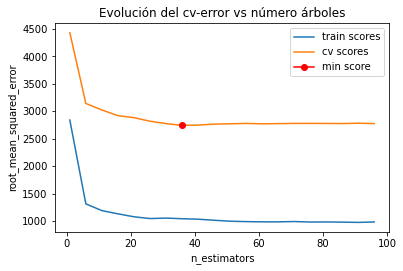

In [26]:
# Validación empleando k-cross-validation y neg_root_mean_squared_error
# ==============================================================================
train_scores = []
cv_scores    = []

# Valores evaluados
estimator_range = range(1, 100, 5)

# Bucle para entrenar un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de k-cross-validation.
for n_estimators in estimator_range:
    
    modelRF = RandomForestRegressor(
                n_estimators = n_estimators,
                criterion    = 'squared_error', #mean squared error: mse
                max_depth    = None,
                max_features = 'auto',
                oob_score    = False,
                n_jobs       = -1,
                random_state = 123
             )
    
    # Error de train
    modelRF.fit(X_Completo, y_Completo)
    predicciones = modelRF.predict(X = X_Completo)
    rmse = mean_squared_error(
            y_true  = y_Completo,
            y_pred  = predicciones,
            squared = False
           )
    train_scores.append(rmse)
    
    # Error de validación cruzada
    scores = cross_val_score(
                estimator = modelRF,
                X         = X_Completo,
                y         = y_Completo,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5
             )
    # Se agregan los scores de cross_val_score() y se pasa a positivo
    cv_scores.append(-1*scores.mean())
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, cv_scores, label="cv scores")
ax.plot(estimator_range[np.argmin(cv_scores)], min(cv_scores),
        marker='o', color = "red", label="min score")
ax.set_ylabel("root_mean_squared_error")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del cv-error vs número árboles")
plt.legend();
print(f"Valor óptimo de n_estimators: {estimator_range[np.argmin(cv_scores)]}")

**Analísis:** Ambas métricas indican que, a partir de 20 árboles (n_estimators), el error de validación del modelo se estabiliza.

Valor óptimo de max_features: 20


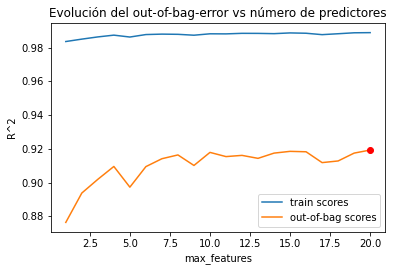

In [27]:
# Validación empleando el Out-of-Bag error
# ==============================================================================
train_scores = []
oob_scores   = []

# Valores evaluados
max_features_range = range(1, X_Completo.shape[1] + 1, 1) #X_train.shape[1] = total de características


# Bucle para entrenar un modelo con cada valor de max_features y extraer su error
# de entrenamiento y de Out-of-Bag.
for max_features in max_features_range:
    modelRF = RandomForestRegressor(
                n_estimators = 20,
                criterion    = 'mse',
                max_depth    = None,
                max_features = max_features,
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    modelRF.fit(X_Completo, y_Completo)
    train_scores.append(modelRF.score(X_Completo, y_Completo))
    oob_scores.append(modelRF.oob_score_)
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(max_features_range, train_scores, label="train scores")
ax.plot(max_features_range, oob_scores, label="out-of-bag scores")
ax.plot(max_features_range[np.argmax(oob_scores)], max(oob_scores),
        marker='o', color = "red")
ax.set_ylabel("R^2")
ax.set_xlabel("max_features")
ax.set_title("Evolución del out-of-bag-error vs número de predictores")
plt.legend();
print(f"Valor óptimo de max_features: {max_features_range[np.argmax(oob_scores)]}")

Valor óptimo de max_features: 7


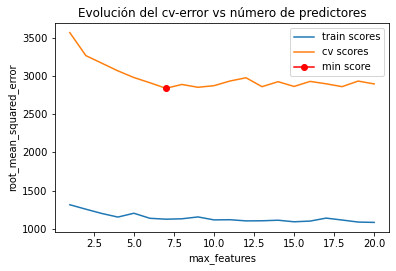

In [28]:
# Validación empleando k-cross-validation y neg_root_mean_squared_error
# ==============================================================================
train_scores = []
cv_scores    = []

# Valores evaluados
max_features_range = range(1, X_Completo.shape[1] + 1, 1)

# Bucle para entrenar un modelo con cada valor de max_features y extraer su error
# de entrenamiento y de k-cross-validation.
for max_features in max_features_range:
    
    modelRF = RandomForestRegressor(
                n_estimators = 20,
                criterion    = 'squared_error',
                max_depth    = None,
                max_features = max_features,
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    
    # Error de train
    modelRF.fit(X_Completo, y_Completo)
    predicciones = modelRF.predict(X = X_Completo)
    rmse = mean_squared_error(
            y_true  = y_Completo,
            y_pred  = predicciones,
            squared = False
           )
    train_scores.append(rmse)
    
    # Error de validación cruzada
    scores = cross_val_score(
                estimator = modelRF,
                X         = X_Completo,
                y         = y_Completo,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5
             )
    # Se agregan los scores de cross_val_score() y se pasa a positivo
    cv_scores.append(-1*scores.mean())
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(max_features_range, train_scores, label="train scores")
ax.plot(max_features_range, cv_scores, label="cv scores")
ax.plot(max_features_range[np.argmin(cv_scores)], min(cv_scores),
        marker='o', color = "red", label="min score")
ax.set_ylabel("root_mean_squared_error")
ax.set_xlabel("max_features")
ax.set_title("Evolución del cv-error vs número de predictores")
plt.legend();
print(f"Valor óptimo de max_features: {max_features_range[np.argmin(cv_scores)]}")

**Analísis:** Ambas métricas indican que, entre 7 y 12 características se obtiene el mejor R^2 y el menor error

In [29]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = ParameterGrid(
                {'n_estimators': [15, 20, 25],
                 'max_features': [7, 9, 11, 12],
                 'max_depth'   : [3, 10, 20]
                }
             )

# Loop para ajustar un modelo con cada combinación de hiperparámetros
# ==============================================================================
resultados = {'params': [], 'oob_r2': []}

for params in param_grid:
    
    modelRF = RandomForestRegressor(
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123,
                ** params
             )
    
    modelRF.fit(X_Completo, y_Completo)
    
    resultados['params'].append(params)
    resultados['oob_r2'].append(modelRF.oob_score_)
    print(f"Modelo: {params} \u2713")

# Resultados
# ==============================================================================
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.drop(columns = 'params')
resultados = resultados.sort_values('oob_r2', ascending=False)
resultados.head(5)

Modelo: {'max_depth': 3, 'max_features': 7, 'n_estimators': 15} ✓
Modelo: {'max_depth': 3, 'max_features': 7, 'n_estimators': 20} ✓
Modelo: {'max_depth': 3, 'max_features': 7, 'n_estimators': 25} ✓
Modelo: {'max_depth': 3, 'max_features': 9, 'n_estimators': 15} ✓
Modelo: {'max_depth': 3, 'max_features': 9, 'n_estimators': 20} ✓
Modelo: {'max_depth': 3, 'max_features': 9, 'n_estimators': 25} ✓
Modelo: {'max_depth': 3, 'max_features': 11, 'n_estimators': 15} ✓
Modelo: {'max_depth': 3, 'max_features': 11, 'n_estimators': 20} ✓
Modelo: {'max_depth': 3, 'max_features': 11, 'n_estimators': 25} ✓
Modelo: {'max_depth': 3, 'max_features': 12, 'n_estimators': 15} ✓
Modelo: {'max_depth': 3, 'max_features': 12, 'n_estimators': 20} ✓
Modelo: {'max_depth': 3, 'max_features': 12, 'n_estimators': 25} ✓
Modelo: {'max_depth': 10, 'max_features': 7, 'n_estimators': 15} ✓
Modelo: {'max_depth': 10, 'max_features': 7, 'n_estimators': 20} ✓
Modelo: {'max_depth': 10, 'max_features': 7, 'n_estimators': 25} ✓
M

,oob_r2,max_depth,max_features,n_estimators
23,0.9266,10,12,25
29,0.9252,20,9,25
35,0.9245,20,12,25
20,0.9222,10,11,25
28,0.9212,20,9,20


In [30]:
# Mejores hiperparámetros por out-of-bag error
# ==============================================================================
print("--------------------------------------------")
print("Mejores hiperparámetros encontrados (oob-r2)")
print("--------------------------------------------")
print(resultados.iloc[0,:]['oob_r2'], "R2")

--------------------------------------------
Mejores hiperparámetros encontrados (oob-r2)
--------------------------------------------
0.9265554593771439 R2


**Analísis:** Con 12 Características, y un maximo nivel de profundidad de 10 se obtiene el mejor R^2 sobre el datatset Out of bag

#### Validación Cruzada

In [31]:
#Se entrena el modelo con múltiples hiperparámetros buscando el mejor


# Definir el modelo AdaBoostRegressor
modelRF = RandomForestRegressor(random_state = 123)


CV = 10


parameters =  {
                'n_estimators': [15, 20, 25],
                'max_features': [9, 10, 11, 12],
                'max_depth'   : [3, 10, 20]
                }

grid_RF = GridSearchCV(
                    estimator  = modelRF,
                    param_grid = parameters,
                    scoring    =  'r2',         #'neg_root_mean_squared_error',
                    n_jobs     = - 1,
                    cv         = CV, 
                    refit      = True,
                    verbose    = 3,
                    return_train_score = True
                   )

grid_RF.fit(X = X_Completo, y = y_Completo)


Fitting 10 folds for each of 36 candidates, totalling 360 fits


GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=123),
             n_jobs=-1,
             param_grid={'max_depth': [3, 10, 20],
                         'max_features': [9, 10, 11, 12],
                         'n_estimators': [15, 20, 25]},
             return_train_score=True, scoring='r2', verbose=3)

In [32]:
# Resultados
resultados = pd.DataFrame(grid_RF.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

,param_max_depth,param_max_features,param_n_estimators,mean_test_score,std_test_score,mean_train_score,std_train_score
17,10,10,25,0.9266,0.0197,0.9823,0.0008
23,10,12,25,0.9264,0.0248,0.9831,0.0008
16,10,10,20,0.9260,0.0204,0.9815,0.0010
14,10,9,25,0.9255,0.0217,0.9821,0.0008


In [33]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)


# Obtener los resultados del grid search
results_grid_RF = pd.DataFrame(grid_RF.cv_results_)


# Seleccionar las columnas deseadas
columns_grid_RF = ['param_max_depth']  + \
                    ['param_max_features']  + \
                    ['param_n_estimators']  + \
                    ['mean_test_score', 'std_test_score']  + \
                    [f'split{i}_test_score' for i in range(CV)]

# Filtrar y mostrar los resultados
results_grid_RF_filtered = results_grid_RF[columns_grid_RF]

# Crear la columna scoreWithStd: f1 / std
results_grid_RF_filtered['scoreWithStd'] = results_grid_RF_filtered.apply(
    lambda row: row['mean_test_score'] / row['std_test_score'] if row['std_test_score'] != 0 else 0,
    axis=1
)

# Encuentra el índice del máximo valor en la columna scoreWithStd
indice_max_scoreWithStd = results_grid_RF_filtered['scoreWithStd'].idxmax()

# Mostrar los scores promedios por cada parámetro
results_grid_RF_filtered[['param_max_depth', 'param_max_features','param_n_estimators', 'mean_test_score', 'std_test_score', 'scoreWithStd']]


,param_max_depth,param_max_features,param_n_estimators,mean_test_score,std_test_score,scoreWithStd
0,3,9,15,0.7971,0.0395,20.2008
1,3,9,20,0.7945,0.0419,18.9817
2,3,9,25,0.7962,0.0371,21.4608
3,3,10,15,0.7856,0.0369,21.2928
4,3,10,20,0.7899,0.0337,23.4581
5,3,10,25,0.7922,0.0333,23.7842
6,3,11,15,0.7920,0.0471,16.8226
7,3,11,20,0.7960,0.0467,17.0325
8,3,11,25,0.7986,0.0447,17.8842
9,3,12,15,0.7914,0.0398,19.9066


In [34]:
# Se identifican los mejores hiperparámetros
best_params = grid_RF.best_params_
print('Best Parameters : ',best_params)

Best Parameters :  {'max_depth': 10, 'max_features': 10, 'n_estimators': 25}


In [35]:
# Top 3 de los mejores scores
results_grid_RF_filtered.sort_values(by='scoreWithStd', ascending=False).head(3)[
    ['param_max_depth', 'param_max_features','param_n_estimators', 'mean_test_score', 'std_test_score', 'scoreWithStd']]

,param_max_depth,param_max_features,param_n_estimators,mean_test_score,std_test_score,scoreWithStd
17,10,10,25,0.9266,0.0197,47.0131
16,10,10,20,0.9260,0.0204,45.3424
15,10,10,15,0.9226,0.0214,43.0312


In [36]:
# Seleccionar el registro correspondiente al índice máximo
registro_max_scoreWithStd = results_grid_RF_filtered.loc[indice_max_scoreWithStd]

registro_max_scoreWithStd.transpose()

param_max_depth           10
param_max_features        10
param_n_estimators        25
mean_test_score       0.9266
std_test_score        0.0197
split0_test_score     0.9321
split1_test_score     0.9266
split2_test_score     0.9350
split3_test_score     0.9458
split4_test_score     0.9010
split5_test_score     0.9266
split6_test_score     0.8814
split7_test_score     0.9480
split8_test_score     0.9269
split9_test_score     0.9427
scoreWithStd         47.0131
Name: 17, dtype: object

In [37]:
results_grid_RF_filtered.loc[indice_max_scoreWithStd]['mean_test_score']

0.9266322768769673

In [38]:
# Usar los mejores parámetros para crear el modelo
#modelRF.set_params(**best_params)

#modelRF.fit(X_Completo, y_Completo)

In [39]:
# Se crea un modelo árbol de decisión con los mejores hiperparámetros 
modelRF = RandomForestRegressor( max_depth = best_params["max_depth"]
                               , max_features = best_params["max_features"]
                               , n_estimators = best_params["n_estimators"]
                               , random_state = 1234)


#Se entrena el modelo con los datos completos
modelRF.fit(X_Completo, y_Completo)

RandomForestRegressor(max_depth=10, max_features=10, n_estimators=25,
                      random_state=1234)

### 8.  Importancia de predictores

#### Importancia por pureza de nodos

In [40]:
importancia_predictores = pd.DataFrame(
                            {'predictor': d.drop(columns = "Price").columns,
                             'importancia': modelRF.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
2,Engine,0.2927
8,PriceRange,0.1644
4,Width,0.1397
0,Year,0.0995
1,Kilometer,0.0837
7,Fuel Tank Capacity,0.0669
11,Transmission_Manual,0.0550
3,Length,0.0435
5,Height,0.0286
18,Drivetrain_FWD,0.0152


### Guardar modelo

In [41]:
#Se guardan los modelos de árboles

joblib.dump(modelRF, './modelos/regresion/RForest_CV.pkl')

['./modelos/regresion/RForest_CV.pkl']

#### Referencias


- Random Forest
    - https://www.cienciadedatos.net/documentos/py08_random_forest_python.html
    - https://fhernanb.github.io/libro_mod_pred/rand-forests.html
    - https://scikit-learn.org/stable/modules/model_evaluation.html
    